# Balancing Model

---

## Imports

In [1]:
import itertools
import json
import os
import pickle
import random
import re
import string

from pathlib import Path

import contractions
import emoji
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords

from tqdm import tqdm

In [2]:
STOP_WORDS = set(stopwords.words("english"))

---

## List Experiments 

In [3]:
parent_folder = Path(f"../experiments/")
all_subfolder = os.listdir(parent_folder)

experiments = list()
for sub in all_subfolder:
    folder = parent_folder / sub
    try:
        with open(folder / "grid_params.json", "r") as f:
            grid = json.load(f)
    except FileNotFoundError:
        continue
    with open(folder / "metrics_validation.json", "r") as f:
        metrics = json.load(f)
    if os.path.exists(folder / "history.pkl"):
        with open(folder / "history.pkl", "rb") as f:
            history = pickle.load(f)
            actual_epochs = len(history["loss"])
    else:
        actual_epochs = 10
    grid["code"] = sub
    grid["f1_macro"] = metrics["f1_macro"]
    grid["actual_epoch"] = actual_epochs
    experiments.append(grid)
experiments = (
    pd.DataFrame(experiments)
    .assign(trainable=lambda f: f["trainable"].fillna("all"))
    .assign(dropout=lambda f: f["dropout"].fillna(0.3))
    .assign(label_smoothing=lambda f: f["label_smoothing"].fillna(0))
    .assign(scheduler=lambda f: f["scheduler"].fillna(0.2))
    .sort_values(by=["f1_macro"], ascending=False)
)

In [4]:
experiments

,model,head,epochs,batch_size,learning_rate,emoji_tagging,clean_data,balancing,augment,minority_shuffling,code,f1_macro,actual_epoch,trainable,dropout,label_smoothing,scheduler
20,bert-base-uncased,none,10,16,0.00005,True,False,none,False,"{'grief_sadness': ['grief', 'sadness'], 'pride...",20230729T214900,0.533222,10,all,0.3,0.00,0.2
21,bert-base-uncased,none,10,16,0.00005,True,False,none,False,"{'grief_sadness': ['grief', 'sadness'], 'pride...",20230729T234627,0.530839,10,all,0.3,0.00,0.2
22,bert-base-uncased,none,10,16,0.00005,True,False,none,False,"{'grief_sadness': ['grief', 'sadness'], 'pride...",20230730T023528,0.526794,10,all,0.3,0.00,0.2
23,bert-base-uncased,none,10,16,0.00005,True,False,none,False,"{'grief_sadness': ['grief', 'sadness'], 'pride...",20230730T054904,0.523855,10,all,0.3,0.00,0.2
18,bert-base-uncased,none,10,16,0.00005,True,False,none,False,"{'grief_sadness': ['grief', 'sadness'], 'nervo...",20230729T180812,0.521718,6,all,0.3,0.00,0.2
19,bert-base-uncased,none,10,16,0.00005,True,False,none,False,"{'neutral': ['neutral'], 'anger': ['anger', 'a...",20230729T212019,0.516967,5,all,0.3,0.00,0.2
16,bert-base-uncased,none,10,16,0.00005,True,False,none,False,"{'grief_sadness': ['grief', 'sadness'], 'nervo...",20230729T133851,0.503661,4,all,0.3,0.00,0.2
8,bert-base-uncased,none,10,16,0.00005,True,False,avg,True,{},20230728T035724,0.502098,3,all,0.3,0.00,0.2
14,bert-base-uncased,none,10,16,0.00005,True,False,avg,True,{},20230728T221009,0.499330,10,all,0.3,0.10,0.2
15,bert-base-uncased,none,2,16,0.00005,True,False,none,False,"{'grief_sadness': ['grief', 'sadness'], 'nervo...",20230729T114058,0.498377,2,all,0.3,0.00,0.2


---

## Configs

In [5]:
EXPERIMENT = "20230727T103203"

---

## Load Experiment 

In [6]:
folder = Path(f"../experiments/{EXPERIMENT}")

with open(folder / "grid_params.json", "r") as f:
    grid = json.load(f)
    
    
if os.path.exists(folder / "history.pkl"):
    with open(folder / "history.pkl", "rb") as f:
        history = pickle.load(f)
elif os.path.exists(folder / "history_0.pkl"):
    history_files = [f for f in os.listdir(folder) if "history_" in f]
    history = dict()
    for file in history_files:
        with open(folder / file, "rb") as f:
            history[int(file.split("_")[-1].replace(".pkl", ""))] = pickle.load(f)
else:
    history = None
    
    
with open(folder / "metrics_validation.json", "r") as f:
    val_metrics = json.load(f)
    
    
with open(folder / "confusion_matrix_validation.pkl", "rb") as f:
    val_confusion_matrix = pickle.load(f)

if os.path.exists(folder / "original_predictions.pkl"):
    with open(folder / "original_predictions.pkl", "rb") as f:
        original_predictions = pickle.load(f)
    
data_for_exp = pd.read_pickle(folder / "data_for_exp.pkl")
predictions = pd.read_pickle(folder / "prediction_validation.pkl")
misclassification = pd.read_pickle(folder / "misclassification_validation.pkl")
correct = data_for_exp.loc[lambda f: f["set"] == "validation"].loc[lambda f: ~f["code"].isin(misclassification.code)]

## Experiment Analysis

In [7]:
#### manual record

{
    "loss": [2.1422, 1.6719, 1.4659, 1.4139, 1.4085],
    "f1_score": [0.4444, 0.5766, 0.6309, 0.6459, 0.6479],
    "val_loss": [1.8115, 1.7900, 1.8577, 1.8693, 1.8715],
    "val_f1_score": [0.5483, 0.5632, 0.5634, 0.5626, 0.5626],
    "lr": [5e-5, 1e05, 2e-6, 4e-7, 8e-8],
}

{'loss': [2.1422, 1.6719, 1.4659, 1.4139, 1.4085],
 'f1_score': [0.4444, 0.5766, 0.6309, 0.6459, 0.6479],
 'val_loss': [1.8115, 1.79, 1.8577, 1.8693, 1.8715],
 'val_f1_score': [0.5483, 0.5632, 0.5634, 0.5626, 0.5626],
 'lr': [5e-05, 100000.0, 2e-06, 4e-07, 8e-08]}

### Metrics Summary 

In [8]:
print(
    f"Macro F1-Score: {val_metrics['f1_macro']:03f}", 
    f"Micro F1-Score: {val_metrics['f1_micro']:03f}", 
    f"ROC-AUC: {val_metrics['roc_auc']:03f}", 
    sep="\n"
)

Macro F1-Score: 0.489880
Micro F1-Score: 0.602789
ROC-AUC: 0.742647


### History 

In [9]:
if history is not None:
    if 0 in history:
        for i in history:
            n = 7
            combinations = list(original_predictions)[i]
            title = "\n".join(["+".join(combinations[i:i+n]) for i in range(0, len(combinations), n)])
            df = pd.DataFrame(history[i])
            df.index += 1
            df = df.rename(columns={"loss": "train_loss"})
            df.plot(y=["train_loss", "val_loss"], xlabel="epochs", ylabel="loss", title=title, figsize=(16, 6))
    else:
        df = pd.DataFrame(history)
        df.index += 1
        df = df.rename(columns={"loss": "train_loss"})
        df.plot(y=["train_loss", "val_loss"], xlabel="epochs", ylabel="loss", figsize=(16, 6))

### Classification Report 

In [10]:
print(val_metrics["classification_report"])

                precision    recall  f1-score   support

    admiration       0.66      0.82      0.73       488
     amusement       0.76      0.85      0.80       303
         anger       0.43      0.59      0.50       195
     annoyance       0.36      0.54      0.43       303
      approval       0.37      0.39      0.38       397
        caring       0.49      0.54      0.51       153
     confusion       0.42      0.44      0.43       152
     curiosity       0.47      0.71      0.57       248
        desire       0.57      0.49      0.53        77
disappointment       0.38      0.34      0.36       163
   disapproval       0.42      0.43      0.42       292
       disgust       0.45      0.46      0.45        97
 embarrassment       0.64      0.51      0.57        35
    excitement       0.39      0.33      0.36        96
          fear       0.67      0.61      0.64        90
     gratitude       0.90      0.90      0.90       358
         grief       0.00      0.00      0.00  

### Confusion Matrix 

<Axes: >

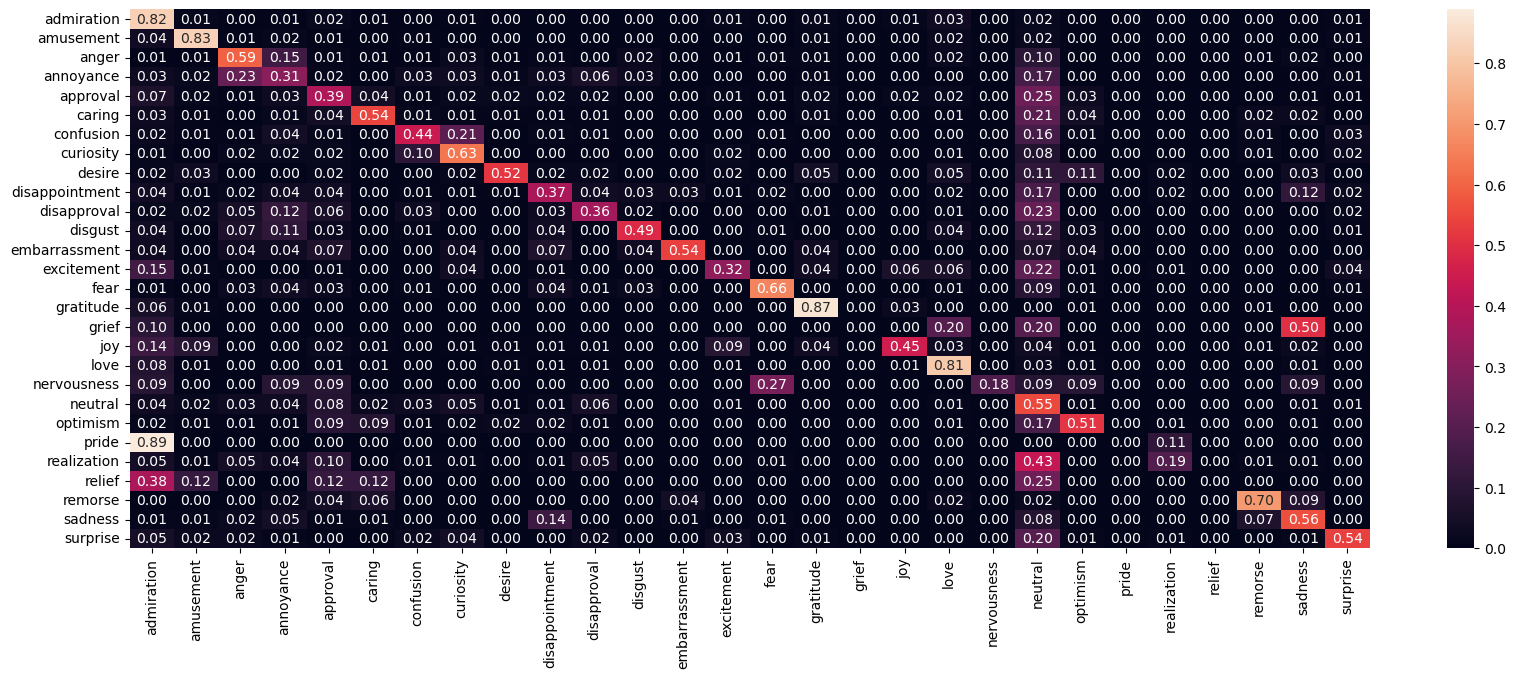

In [11]:
cm = val_confusion_matrix
cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(20,7))
sns.heatmap(
    pd.DataFrame(
        cm,
        columns=sorted(list(data_for_exp.goemotion.unique())),
        index=sorted(list(data_for_exp.goemotion.unique()))
    ),
    annot=True,
    fmt="1.2f"
)

### Misclassification Analysis 

In [12]:
PUNCUATION_LIST = list(string.punctuation)

In [13]:
c_dict = list(contractions.slang_dict) + list(contractions.contractions_dict)

In [14]:
for emotion in ["all"] + list(set(data_for_exp.goemotion)):
    results = list()
    for n, df in [("correct", correct), ("misclassified", misclassification)]:
        if emotion != "all":
            df = df.loc[lambda f: f["goemotion"] == emotion]
            
        if df.shape[0] == 0:
            continue
        
        # compute values in the dataset
        df = df.assign(
            chars=lambda f: f["text"].apply(len),
            tokens=lambda f: f["text"].str.split().apply(len),
            emojis=lambda f: f.text.apply(lambda x: len([c for c in x if c in emoji.EMOJI_DATA])),
            stop_words=lambda f: f.text.str.split().apply(lambda x: len([t for t in x if t.lower() in STOP_WORDS])),
            high_case=lambda f: f.text.apply(lambda x: len([c for c in x if not c.islower()])),
            contractions=lambda f: f.text.str.split().apply(lambda x: len([t for t in x if t in c_dict])),
            ponctuation=lambda f: f.text.apply(lambda x: len([c for c in x if c in PUNCUATION_LIST])),
        )

        # compile statiscs
        char_length = df["chars"].mean()
        tokens = df["tokens"].mean()
        high_case_rate = df.high_case.sum() / df.chars.sum()
        emoji_rate = df.emojis.sum() / df.chars.sum()
        stop_words = df["stop_words"].sum() / df["tokens"].sum()
        contractions = df["contractions"].sum() / df["tokens"].sum()
        ponctuations = df["ponctuation"].sum() / df["chars"].sum()

        results.append({
            "type": n,
            "char_length": char_length,
            "token_length": tokens,
            "case_rate": high_case_rate,
            "ponctuations_rate": ponctuations,
            "emoji_rate": emoji_rate,
            "stop_words_rate": stop_words,
            "contraction_rate": contractions
        })

    display(
        pd.DataFrame(results)
        .set_index(["type"]).T
        .assign(emotion=emotion)
        .reindex(columns=["emotion", "correct", "misclassified"])
        .assign(delta=lambda f: f["misclassified"] - f["correct"])
        .assign(rate=lambda f: f["misclassified"] / f["correct"])
    )

type,emotion,correct,misclassified,delta,rate
char_length,all,65.330260,74.425370,9.095110,1.139217
token_length,all,12.213188,13.999104,1.785915,1.146228
case_rate,all,0.266431,0.266371,-0.000060,0.999775
ponctuations_rate,all,0.040254,0.038948,-0.001306,0.967557
emoji_rate,all,0.000441,0.000813,0.000373,1.845662
stop_words_rate,all,0.435565,0.443551,0.007986,1.018335
contraction_rate,all,0.028666,0.031506,0.002841,1.099094


type,emotion,correct,misclassified,delta,rate
char_length,joy,73.719512,67.052632,-6.666881,0.909564
token_length,joy,14.036585,12.868421,-1.168164,0.916777
case_rate,joy,0.267494,0.271978,0.004484,1.016764
ponctuations_rate,joy,0.040364,0.041013,0.000649,1.016069
emoji_rate,joy,0.000496,0.000589,0.000092,1.186224
stop_words_rate,joy,0.423110,0.446830,0.023720,1.056061
contraction_rate,joy,0.038228,0.024540,-0.013688,0.641941


type,emotion,correct,misclassified,delta,rate
char_length,realization,85.478261,84.448980,-1.029281,0.987959
token_length,realization,15.913043,15.826531,-0.086513,0.994563
case_rate,realization,0.252289,0.264741,0.012453,1.049358
ponctuations_rate,realization,0.037640,0.036612,-0.001028,0.972689
emoji_rate,realization,0.000000,0.000725,0.000725,inf
stop_words_rate,realization,0.508197,0.459703,-0.048493,0.904578
contraction_rate,realization,0.016393,0.027724,0.011331,1.691167


type,emotion,correct,misclassified,delta,rate
char_length,relief,NaN,70.500000,NaN,NaN
token_length,relief,NaN,13.166667,NaN,NaN
case_rate,relief,NaN,0.292356,NaN,NaN
ponctuations_rate,relief,NaN,0.041765,NaN,NaN
emoji_rate,relief,NaN,0.000000,NaN,NaN
stop_words_rate,relief,NaN,0.400844,NaN,NaN
contraction_rate,relief,NaN,0.033755,NaN,NaN


type,emotion,correct,misclassified,delta,rate
char_length,approval,68.955882,74.289256,5.333374,1.077345
token_length,approval,12.764706,13.946281,1.181575,1.092566
case_rate,approval,0.252293,0.264935,0.012642,1.050110
ponctuations_rate,approval,0.039028,0.037935,-0.001092,0.972013
emoji_rate,approval,0.000533,0.001279,0.000746,2.399533
stop_words_rate,approval,0.431452,0.447704,0.016252,1.037668
contraction_rate,approval,0.025922,0.026667,0.000745,1.028741


type,emotion,correct,misclassified,delta,rate
char_length,remorse,71.054054,86.052632,14.998578,1.211087
token_length,remorse,13.000000,16.473684,3.473684,1.267206
case_rate,remorse,0.275010,0.248318,-0.026691,0.902943
ponctuations_rate,remorse,0.054013,0.033639,-0.020374,0.622798
emoji_rate,remorse,0.000380,0.000612,0.000231,1.607951
stop_words_rate,remorse,0.403326,0.476038,0.072712,1.180281
contraction_rate,remorse,0.047817,0.038339,-0.009478,0.801778


type,emotion,correct,misclassified,delta,rate
char_length,grief,NaN,70.230769,NaN,NaN
token_length,grief,NaN,13.846154,NaN,NaN
case_rate,grief,NaN,0.258488,NaN,NaN
ponctuations_rate,grief,NaN,0.033954,NaN,NaN
emoji_rate,grief,NaN,0.000000,NaN,NaN
stop_words_rate,grief,NaN,0.422222,NaN,NaN
contraction_rate,grief,NaN,0.016667,NaN,NaN


type,emotion,correct,misclassified,delta,rate
char_length,excitement,51.434783,55.312500,3.877717,1.075391
token_length,excitement,9.782609,10.078125,0.295516,1.030208
case_rate,excitement,0.323753,0.283051,-0.040702,0.874280
ponctuations_rate,excitement,0.056636,0.053672,-0.002963,0.947677
emoji_rate,excitement,0.000000,0.001130,0.001130,inf
stop_words_rate,excitement,0.368889,0.386047,0.017158,1.046512
contraction_rate,excitement,0.048889,0.024806,-0.024083,0.507400


type,emotion,correct,misclassified,delta,rate
char_length,surprise,78.343284,65.980000,-12.363284,0.842191
token_length,surprise,14.537313,12.540000,-1.997313,0.862608
case_rate,surprise,0.270337,0.289785,0.019448,1.071938
ponctuations_rate,surprise,0.038674,0.049409,0.010735,1.277573
emoji_rate,surprise,0.000572,0.000606,0.000035,1.060725
stop_words_rate,surprise,0.437372,0.421053,-0.016319,0.962688
contraction_rate,surprise,0.047228,0.039872,-0.007356,0.844255


type,emotion,correct,misclassified,delta,rate
char_length,love,62.090395,72.105263,10.014868,1.161295
token_length,love,12.265537,13.868421,1.602884,1.130682
case_rate,love,0.281893,0.281022,-0.000871,0.996911
ponctuations_rate,love,0.038035,0.043066,0.005031,1.132277
emoji_rate,love,0.002639,0.004015,0.001376,1.521394
stop_words_rate,love,0.427913,0.421252,-0.006661,0.984434
contraction_rate,love,0.017964,0.022770,0.004806,1.267552


type,emotion,correct,misclassified,delta,rate
char_length,pride,NaN,68.800000,NaN,NaN
token_length,pride,NaN,13.133333,NaN,NaN
case_rate,pride,NaN,0.245155,NaN,NaN
ponctuations_rate,pride,NaN,0.037791,NaN,NaN
emoji_rate,pride,NaN,0.000000,NaN,NaN
stop_words_rate,pride,NaN,0.487310,NaN,NaN
contraction_rate,pride,NaN,0.055838,NaN,NaN


type,emotion,correct,misclassified,delta,rate
char_length,sadness,65.202899,83.700000,18.497101,1.283685
token_length,sadness,12.855072,15.700000,2.844928,1.221308
case_rate,sadness,0.281840,0.265950,-0.015891,0.943618
ponctuations_rate,sadness,0.045566,0.041338,-0.004228,0.907220
emoji_rate,sadness,0.001556,0.000956,-0.000600,0.614303
stop_words_rate,sadness,0.458850,0.422930,-0.035920,0.921717
contraction_rate,sadness,0.029312,0.038217,0.008904,1.303773


type,emotion,correct,misclassified,delta,rate
char_length,disappointment,81.717949,75.592593,-6.125356,0.925043
token_length,disappointment,15.205128,14.435185,-0.769943,0.949363
case_rate,disappointment,0.247568,0.263596,0.016028,1.064742
ponctuations_rate,disappointment,0.030436,0.039196,0.008760,1.287826
emoji_rate,disappointment,0.000000,0.000245,0.000245,inf
stop_words_rate,disappointment,0.448567,0.442591,-0.005975,0.986679
contraction_rate,disappointment,0.037099,0.035920,-0.001179,0.968220


type,emotion,correct,misclassified,delta,rate
char_length,nervousness,97.166667,71.714286,-25.452381,0.738054
token_length,nervousness,16.333333,13.928571,-2.404762,0.852770
case_rate,nervousness,0.224700,0.262948,0.038248,1.170220
ponctuations_rate,nervousness,0.029160,0.042829,0.013669,1.468772
emoji_rate,nervousness,0.000000,0.000000,0.000000,NaN
stop_words_rate,nervousness,0.428571,0.461538,0.032967,1.076923
contraction_rate,nervousness,0.081633,0.041026,-0.040607,0.502564


type,emotion,correct,misclassified,delta,rate
char_length,confusion,81.781818,77.388235,-4.393583,0.946277
token_length,confusion,15.636364,14.835294,-0.801070,0.948769
case_rate,confusion,0.255892,0.283521,0.027629,1.107973
ponctuations_rate,confusion,0.035794,0.043174,0.007381,1.206196
emoji_rate,confusion,0.000000,0.000000,0.000000,NaN
stop_words_rate,confusion,0.482558,0.484536,0.001978,1.004099
contraction_rate,confusion,0.045349,0.025377,-0.019972,0.559588


type,emotion,correct,misclassified,delta,rate
char_length,anger,56.888889,69.708861,12.819972,1.225351
token_length,anger,10.636364,13.000000,2.363636,1.222222
case_rate,anger,0.294744,0.273652,-0.021093,0.928438
ponctuations_rate,anger,0.043324,0.039223,-0.004101,0.905340
emoji_rate,anger,0.000533,0.000182,-0.000351,0.340899
stop_words_rate,anger,0.425451,0.451801,0.026350,1.061935
contraction_rate,anger,0.022792,0.020448,-0.002344,0.897152


type,emotion,correct,misclassified,delta,rate
char_length,curiosity,61.137255,80.152778,19.015523,1.311030
token_length,curiosity,11.522876,15.055556,3.532680,1.306580
case_rate,curiosity,0.267907,0.271357,0.003450,1.012878
ponctuations_rate,curiosity,0.045221,0.041414,-0.003807,0.915807
emoji_rate,curiosity,0.000107,0.000347,0.000240,3.241726
stop_words_rate,curiosity,0.475893,0.467712,-0.008181,0.982809
contraction_rate,curiosity,0.027226,0.030443,0.003216,1.118139


type,emotion,correct,misclassified,delta,rate
char_length,fear,59.717391,78.314286,18.596894,1.311415
token_length,fear,11.065217,13.828571,2.763354,1.249733
case_rate,fear,0.251183,0.241153,-0.010030,0.960068
ponctuations_rate,fear,0.036039,0.037578,0.001538,1.042681
emoji_rate,fear,0.000000,0.000000,0.000000,NaN
stop_words_rate,fear,0.451866,0.411157,-0.040709,0.909908
contraction_rate,fear,0.023576,0.028926,0.005350,1.226928


type,emotion,correct,misclassified,delta,rate
char_length,neutral,64.627543,72.779904,8.152361,1.126144
token_length,neutral,12.005477,13.614833,1.609355,1.134052
case_rate,neutral,0.272853,0.265104,-0.007749,0.971602
ponctuations_rate,neutral,0.041371,0.038097,-0.003274,0.920872
emoji_rate,neutral,0.000291,0.001249,0.000959,4.298660
stop_words_rate,neutral,0.437463,0.437006,-0.000458,0.998954
contraction_rate,neutral,0.026722,0.033562,0.006839,1.255947


type,emotion,correct,misclassified,delta,rate
char_length,caring,66.441176,78.428571,11.987395,1.180421
token_length,caring,12.294118,14.914286,2.620168,1.213124
case_rate,caring,0.246791,0.256284,0.009494,1.038468
ponctuations_rate,caring,0.040283,0.035519,-0.004764,0.881733
emoji_rate,caring,0.000221,0.000364,0.000143,1.645902
stop_words_rate,caring,0.430622,0.448276,0.017654,1.040996
contraction_rate,caring,0.034689,0.033525,-0.001164,0.966442


type,emotion,correct,misclassified,delta,rate
char_length,gratitude,57.974265,70.861111,12.886846,1.222286
token_length,gratitude,10.823529,13.472222,2.648693,1.244716
case_rate,gratitude,0.270784,0.267738,-0.003046,0.988750
ponctuations_rate,gratitude,0.044771,0.039984,-0.004787,0.893078
emoji_rate,gratitude,0.000380,0.000392,0.000012,1.030250
stop_words_rate,gratitude,0.415082,0.397938,-0.017143,0.958699
contraction_rate,gratitude,0.026495,0.024742,-0.001752,0.933862


type,emotion,correct,misclassified,delta,rate
char_length,disapproval,67.424779,78.491018,11.066239,1.164127
token_length,disapproval,12.292035,14.610778,2.318743,1.188638
case_rate,disapproval,0.248720,0.267013,0.018292,1.073545
ponctuations_rate,disapproval,0.039244,0.034788,-0.004456,0.886452
emoji_rate,disapproval,0.000394,0.000458,0.000064,1.162496
stop_words_rate,disapproval,0.457163,0.451639,-0.005524,0.987917
contraction_rate,disapproval,0.053996,0.040984,-0.013012,0.759016


type,emotion,correct,misclassified,delta,rate
char_length,desire,53.878788,73.871795,19.993007,1.371074
token_length,desire,11.393939,14.948718,3.554779,1.311989
case_rate,desire,0.305962,0.297466,-0.008496,0.972233
ponctuations_rate,desire,0.039370,0.040958,0.001588,1.040333
emoji_rate,desire,0.000562,0.001041,0.000479,1.851440
stop_words_rate,desire,0.468085,0.468268,0.000182,1.000390
contraction_rate,desire,0.034574,0.022298,-0.012276,0.644940


type,emotion,correct,misclassified,delta,rate
char_length,disgust,80.647059,79.596154,-1.050905,0.986969
token_length,disgust,14.470588,14.538462,0.067873,1.004690
case_rate,disgust,0.246535,0.245470,-0.001065,0.995678
ponctuations_rate,disgust,0.035740,0.033583,-0.002157,0.939638
emoji_rate,disgust,0.000365,0.000483,0.000119,1.324958
stop_words_rate,disgust,0.434959,0.433862,-0.001097,0.997478
contraction_rate,disgust,0.020325,0.026455,0.006130,1.301587


type,emotion,correct,misclassified,delta,rate
char_length,admiration,62.664615,71.333333,8.668718,1.138335
token_length,admiration,11.590769,13.540230,1.949461,1.168191
case_rate,admiration,0.256310,0.259265,0.002956,1.011532
ponctuations_rate,admiration,0.038397,0.036900,-0.001498,0.960998
emoji_rate,admiration,0.000295,0.000322,0.000028,1.093888
stop_words_rate,admiration,0.408282,0.440577,0.032295,1.079099
contraction_rate,admiration,0.021503,0.028862,0.007360,1.342283


type,emotion,correct,misclassified,delta,rate
char_length,annoyance,73.496063,72.647482,-0.848581,0.988454
token_length,annoyance,13.464567,13.510791,0.046224,1.003433
case_rate,annoyance,0.244911,0.261240,0.016329,1.066672
ponctuations_rate,annoyance,0.035569,0.041790,0.006222,1.174916
emoji_rate,annoyance,0.000000,0.000594,0.000594,inf
stop_words_rate,annoyance,0.452047,0.446752,-0.005295,0.988287
contraction_rate,annoyance,0.032164,0.041001,0.008837,1.274760


type,emotion,correct,misclassified,delta,rate
char_length,embarrassment,62.833333,86.470588,23.637255,1.376190
token_length,embarrassment,11.416667,16.058824,4.642157,1.406612
case_rate,embarrassment,0.250663,0.240136,-0.010527,0.958003
ponctuations_rate,embarrassment,0.038462,0.034014,-0.004448,0.884354
emoji_rate,embarrassment,0.000000,0.000680,0.000680,inf
stop_words_rate,embarrassment,0.452555,0.454212,0.001658,1.003663
contraction_rate,embarrassment,0.014599,0.021978,0.007379,1.505495


type,emotion,correct,misclassified,delta,rate
char_length,amusement,61.828571,70.260870,8.432298,1.136382
token_length,amusement,11.628571,13.369565,1.740994,1.149717
case_rate,amusement,0.258318,0.278465,0.020147,1.077995
ponctuations_rate,amusement,0.036815,0.041151,0.004336,1.117792
emoji_rate,amusement,0.000693,0.003403,0.002710,4.910066
stop_words_rate,amusement,0.416871,0.424390,0.007519,1.018036
contraction_rate,amusement,0.027437,0.032520,0.005084,1.185293


type,emotion,correct,misclassified,delta,rate
char_length,optimism,78.094737,79.976190,1.881454,1.024092
token_length,optimism,14.821053,15.047619,0.226566,1.015287
case_rate,optimism,0.257986,0.258857,0.000871,1.003374
ponctuations_rate,optimism,0.034910,0.036171,0.001261,1.036124
emoji_rate,optimism,0.000000,0.000595,0.000595,inf
stop_words_rate,optimism,0.446023,0.438291,-0.007732,0.982665
contraction_rate,optimism,0.028409,0.030063,0.001654,1.058228


### Phrase Example 

In [15]:
for e, p in val_metrics["misclassification_examples"].items():
    print("=" * 125)
    print(e)
    print("=" * 125)
    for v in p:
        print(v)
        print()

admiration
Wow it's almost as if those losers have a lot of money or something else to leech off of.

Thanks so much for sharing! I really appreciate you sharing your thoughts and helping me feel less alone. I too hope that it gets better for you!

Wow. [NAME] is a giant POS. He'll be really happy being single and dying alone.

amusement
Omg so true 😂

That's crazy, my brother's cat did the same thing with me last year when I got the flu. She's usually pretty distant

I am confused. I don't understand how that relates to what I said. Could you explain? Sorry, maybe I'm just tired lol

anger
Look at that shit-eating grin

He gets paid to hate them... what's hard to understand?

YOU KNOW HOW MUCH I SACRIFICED?

annoyance
Into what shit? I like her but Idk she’s hella confusing

I’m 40 and I’ve never lied about my age or weight. People take themselves so seriously!

I saw this on here less than 2 days ago. You could at least repost old content that we haven't seen in a while.

approval
Ye

---